На основе ТЕХНИЧЕСКОГО РЕГЛАМЕНТА ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА" сделайте нейро-консультанта, отвечающего на вопросы по документу и поддерживающему диалог. Установите адекватный порог релевантности чанков (используйте similarity_search_with_score вместо similarity_search), то есть, для ответа на вопрос пользователя у вас должны подтягиваться только чанки, находящиеся в пределах данного порога, а остальные - отбрасываться.Нужно провести 1-2 эксперимента с разными порогами.


Проработайте промпт самостоятельно. Нейро-консультант не должен отвечать на вопросы, не касающиеся документа, то есть, он, если скоры всех найденных чанков выше определенного, установленного вами, порога, то нейро-консультант должен отвечать фразу-заглушку.
Сделайте нейро-консультанта, проверьте его работу на самостоятельно-сформулированных вопросах. В ответе нейро-консультанта выводите также скоры найденных чанков (не только отфильтрованных, а всех, найденных при помощи метода similarity_search_with_score).

Ссылка на регламент: https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing

In [1]:
!pip install -q langchain_openai==0.1.22 faiss-cpu==1.8.0 openai==1.55.3 tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12 langchain-text-splitters==0.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 578.7 kB/s eta 0:00:00


In [26]:
# импортируем необходимые библиотеки
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
import os
import re
import requests
import openai
import tiktoken
import matplotlib.pyplot as plt
from textwrap import fill

import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [27]:
from google.colab import userdata

# Использование ключа API от ProxyAPI
key = userdata.get('PROXY_API_KEY')
os.environ["OPENAI_API_KEY"] = key

# Адрес сервера ProxyAPI
base_url = 'https://api.proxyapi.ru/openai/v1'
os.environ["OPENAI_BASE_URL"] = base_url

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = OpenAI()

In [28]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [30]:
# База знаний, которая будет подаваться в langChain
database= load_document_text('https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing')

In [31]:
database[:1000]

'\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\r\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\r\nПОДВИЖНОГО СОСТАВА"\r\n \r\n(ТР ТС 001/2011)\r\n \r\n\r\n\r\n\t \r\nI. Область применения\r\n \r\n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\r\nЖелезнодорожный подвижной состав включает в себя:\r\nлокомотивы;\r\nмоторвагонный подвижной состав и его вагоны;\r\nпассажирские вагоны локомотивной тяги;\r\nгрузовые вагоны;\r\nспециальный железнодорожный подвижной состав.\r\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.\

In [32]:
# предобработаем текст таким образом, чтобы его можно было бы поделить на чанки при помощи MarkdownHeaderTextSplitter
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    '''Далее используем функцию re.sub из модуля регулярных выражений re для замены подстрок в строке text.
    Шаблон регулярного выражения (I{1,3}|IV|V)\. (.+) ищет римские числа от I до V в начале строки, за которыми следует точка и пробел.
    Функция replace_header1 вызывается для каждого совпадения, и ее возвращаемое значение используется для замены найденной подстроки.
    Флаг re.M позволяет ^ соответствовать началу каждой строки, а не только началу всего текста.'''
    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [33]:
markdown = text_to_markdown(database)                 # заполните необходимым значением
print(markdown[:15000])

﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"
 
(ТР ТС 001/2011)
 


	 
# Область применения
Область применения
 
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.
2. Настоящий технический регламент не распр

In [34]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1CEn5ZPLAjL7Hj1ZbfsNNPPZmxk6QlmtBMdbEx-tPcBQ/edit?usp=sharing')

In [35]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=20, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks, fragments

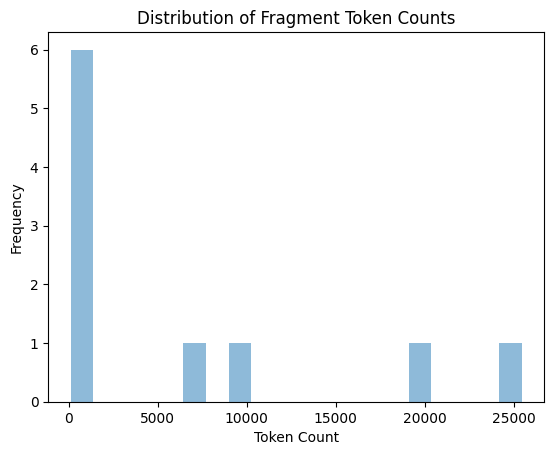

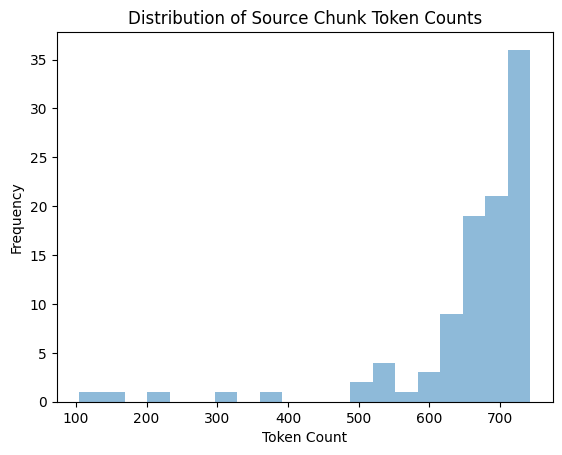

Общее количество чанков:  100


In [36]:
source_chunks, fragments = split_text(markdown, 750)
print("Общее количество чанков: ",len(source_chunks))

In [37]:
# Инициализирум модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(source_chunks, embeddings)                            # заполните необходимыми значениями

In [38]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [44]:
def answer_index(system, search_query, topic, search_index,threshold, verbose=0):
    # Поиск релевантных отрезков из базы знаний по вопросу пользователя
    docs = search_index.similarity_search_with_score(search_query, k=10)

    for doc, score in docs:
      print(f"Сходство: {score:.4f}\nТекст: {doc.page_content}\n")

    docs = [doc for doc, score in docs if score >= threshold]
    print(f"Порог: {threshold}, количество чанков: {len(docs)}")
    if verbose:
        print('\n ===========================================: ')



    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, (doc, score) in enumerate(docs)]))
    if verbose:
        print('message_content :\n ======================================== \n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос пользователя. Документы с информацией для ответа клиенту: {message_content}\n\n{topic}"}
    ]

    if verbose:
        print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini",                                      # заполните необходимыми значениями
        messages=messages,
        temperature=0.2                                   # заполните необходимыми значениями
    )
    answer = completion.choices[0].message.content
    return answer


In [40]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-4o-mini",      # заполните необходимыми значениями
        messages=messages,
        temperature=0,          # Используем более низкую температуру для более определенной суммаризации
    )

    return completion.choices[0].message.content

In [41]:
def answer_user_question_dialog(system, db, user_question, question_history, threshold):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " +summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    answer_text = answer_index(system, user_question, topic, db, threshold)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


In [42]:
def run_dialog(system_doc_url, knowledge_base_url, threshold):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history, threshold)
        print('Консультант:', insert_newlines(answer))

    return

In [45]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db, 0.65)

Пользователь: На какие вагоны не распространяет регламент?
Сходство: 0.3038
Текст: "пассажирские вагоны" - вагоны, предназначенные для перевозки пассажиров, багажа, почтовых отправлений, в том числе почтовые, багажные, вагоны-рестораны, служебно-технические, служебные, клубы, санитарные вагоны, вагоны-лаборатории;
"пневматический тормоз" - тормоз с пневматическим управлением;
"подконтрольная эксплуатация" - штатная эксплуатация железнодорожного подвижного состава, сопровождающаяся дополнительным контролем и учетом технического состояния железнодорожного подвижного состава;
"поезд" - сформированный и сцепленный состав вагонов с одним или несколькими действующими локомотивами или моторными вагонами, имеющий установленные сигналы, а также отправляемые на перегон и находящиеся на перегоне локомотивы без вагонов и специальный самоходный железнодорожный подвижной состав;
"пожарная безопасность" - безопасность железнодорожного подвижного состава, при которой отсутствует возможность возникнове

In [46]:
run_dialog(system, db, 0.80)

Пользователь: На какие вагоны не распространяет регламент?
Сходство: 0.3038
Текст: "пассажирские вагоны" - вагоны, предназначенные для перевозки пассажиров, багажа, почтовых отправлений, в том числе почтовые, багажные, вагоны-рестораны, служебно-технические, служебные, клубы, санитарные вагоны, вагоны-лаборатории;
"пневматический тормоз" - тормоз с пневматическим управлением;
"подконтрольная эксплуатация" - штатная эксплуатация железнодорожного подвижного состава, сопровождающаяся дополнительным контролем и учетом технического состояния железнодорожного подвижного состава;
"поезд" - сформированный и сцепленный состав вагонов с одним или несколькими действующими локомотивами или моторными вагонами, имеющий установленные сигналы, а также отправляемые на перегон и находящиеся на перегоне локомотивы без вагонов и специальный самоходный железнодорожный подвижной состав;
"пожарная безопасность" - безопасность железнодорожного подвижного состава, при которой отсутствует возможность возникнове